In [1]:
import time
from IPython.core.display import display, HTML
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

from pydrake.geometry import StartMeshcat
from pydrake.geometry import MeshcatVisualizer, Rgba, StartMeshcat
from pydrake.geometry.optimization import Point
from pydrake.planning import GcsTrajectoryOptimization

from underactuated import running_as_notebook
from underactuated.uav_environment import (
    CONVEX_GCS_OPTION,
    NONLINEAR_GCS_OPTION,
    UavEnvironment,
)

# from underactuated.uav_environment import *
from custom_uav_env import *

/tmp/ipykernel_933/3175703336.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [11]:
uav_env = UavEnvironment(seed=1, environment_shape=(7, 7))
uav_env.DEFAULT_GOAL = (10., 10., 0.5)
regions, edges_between_regions = uav_env.compile()

In [12]:
def solve_gcs():

    # The maximum velocity limits for the skydio2
    # were obtained from their website.
    qDt_max = 16.0
    # While the maximum acceleration are not publicly available, we assume
    # an estimated thrust to weight ratio of something slightly greater than 2.
    qDDt_max = 10.0

    gcs = GcsTrajectoryOptimization(3)
    main = gcs.AddRegions(regions, edges_between_regions, order=6, h_min=0, h_max=20)
    source = gcs.AddRegions(
        [Point(uav_env.DEFAULT_START)], order=0, h_min=0, h_max=0, name="source"
    )
    target = gcs.AddRegions(
        [Point(uav_env.DEFAULT_GOAL)], order=0, h_min=0, h_max=0, name="target"
    )
    source_to_main = gcs.AddEdges(source, main)
    main_to_target = gcs.AddEdges(main, target)

    source_to_main.AddZeroDerivativeConstraints(1)
    main_to_target.AddZeroDerivativeConstraints(1)
    source_to_main.AddZeroDerivativeConstraints(2)
    main_to_target.AddZeroDerivativeConstraints(2)

    gcs.AddVelocityBounds(3 * [-qDt_max], 3 * [qDt_max])

    gcs.AddTimeCost()
    gcs.AddPathLengthCost()

    start_time = time.time()
    baseline_traj, result = gcs.SolvePath(source, target, CONVEX_GCS_OPTION)
    print(
        f"Is successful: {result.is_success()} in {round(time.time() - start_time, 3)} seconds."
    )
    print(
        f"Total trajectory time: {round(baseline_traj.end_time() - baseline_traj.start_time(), 3)} seconds."
    )
    return baseline_traj, result

In [13]:
# The maximum velocity limits for the skydio2
# were obtained from their website.
qDt_max = 16.0
# While the maximum acceleration are not publicly available, we assume
# an estimated thrust to weight ratio of something slightly greater than 2.
qDDt_max = 10.0

gcs = GcsTrajectoryOptimization(3)
main = gcs.AddRegions(regions, edges_between_regions, order=6, h_min=0, h_max=20)
source = gcs.AddRegions(
    [Point(uav_env.DEFAULT_START)], order=0, h_min=0, h_max=0, name="source"
)
target = gcs.AddRegions(
    [Point(uav_env.DEFAULT_GOAL)], order=0, h_min=0, h_max=0, name="target"
)
source_to_main = gcs.AddEdges(source, main)
main_to_target = gcs.AddEdges(main, target)

source_to_main.AddZeroDerivativeConstraints(1)
main_to_target.AddZeroDerivativeConstraints(1)
source_to_main.AddZeroDerivativeConstraints(2)
main_to_target.AddZeroDerivativeConstraints(2)

gcs.AddVelocityBounds(3 * [-qDt_max], 3 * [qDt_max])

gcs.AddTimeCost()
gcs.AddPathLengthCost()


CONVEX_GCS_OPTION.preprocessing = True
CONVEX_GCS_OPTION.convex_relaxation = True


CONVEX_GCS_OPTION.max_rounded_paths = 0
CONVEX_GCS_OPTION.max_rounding_trials = 0

result = gcs.graph_of_convex_sets().SolveShortestPath(source.Vertices()[0], target.Vertices()[0], CONVEX_GCS_OPTION)

CONVEX_GCS_OPTION.max_rounded_paths = 300
CONVEX_GCS_OPTION.max_rounding_trials = 300

paths = gcs.graph_of_convex_sets().SamplePaths(source.Vertices()[0], target.Vertices()[0], result, CONVEX_GCS_OPTION)

# CONVEX_GCS_OPTION.max_rounded_paths = 1
start_time = time.time()
best_traj, best_result = gcs.SolvePath(source, target, CONVEX_GCS_OPTION)
print(
    f"Is successful: {best_result.is_success()} in {round(time.time() - start_time, 3)} seconds."
)
print(
    f"Total trajectory time: {round(best_traj.end_time() - best_traj.start_time(), 3)} seconds."
)
# print(best_result.get_optimal_cost())
# result = gcs.graph_of_convex_sets().SamplePaths(source.Vertices()[0], target.Vertices()[0], result, CONVEX_GCS_OPTION)


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Found 39 unique paths, discarded 261 duplicate paths.


AttributeError: 'numpy.float64' object has no attribute 'time'

In [ ]:
vertex_to_subgraph = {}
for sg in gcs.GetSubgraphs():
    for v in sg.Vertices():
        vertex_to_subgraph[v] = sg

In [ ]:
def reconstruct_trajectory_from_solution_path(edges, rounded_result):
    bezier_curves = []
    for e in edges:
        phi_inv = 1. / rounded_result.GetSolution(e.phi())
        num_control_points = vertex_to_subgraph[e.u()].order() + 1
        # edge_path_points = 
        # print(rounded_result.GetSolution(e.xu()).shape, num_control_points)
        # total += (rounded_result.GetSolution(e.xu())[-1])
        xu_result = rounded_result.GetSolution(e.xu())
        h = phi_inv * xu_result[-1]
        edge_path_points = xu_result[:-1].reshape(num_control_points, gcs.num_positions()).T

        start_time = 0 if len(bezier_curves) == 0 else bezier_curves[-1].end_time()

        if num_control_points > 1 and h < 1e-10:
            # TODO
            pass
        elif not (num_control_points == 1): # TODO: enforce && vertex_to_subgraph_[&e->u()]->h_min_ == 0))
            bc = BezierCurve(start_time, start_time + h, edge_path_points)
            bezier_curves.append(bc)

    return CompositeTrajectory(bezier_curves)
        

In [ ]:
best_rounded_result = None
path_edges_list = []
traj_list = []
for path in paths:
    rounded_result = gcs.graph_of_convex_sets().SolveConvexRestriction(path, CONVEX_GCS_OPTION, result)
    if rounded_result.is_success():
        print(f"Success with cost {rounded_result.get_optimal_cost()}")
        path_edges = gcs.graph_of_convex_sets().GetSolutionPath(source.Vertices()[0], target.Vertices()[0], rounded_result, 1.)

        traj = reconstruct_trajectory_from_solution_path(path_edges, rounded_result)
        
        path_edges_list.append(path_edges)
        traj_list.append(traj)

        print(
            f"Total trajectory time: {round(traj.end_time() - traj.start_time(), 3)} seconds."
        )
        # if best_rounded_result is None or best_rounded_result.get_optimal_cost() > rounded_result.get_optimal_cost():
        #     best_rounded_result = rounded_result
        #     path_edges = gcs.graph_of_convex_sets().GetSolutionPath(source.Vertices()[0], target.Vertices()[0], rounded_result, 1.)

    else:
        print("Failed")

Success with cost 22.850240564338478
Total trajectory time: 1.335 seconds.


In [14]:
times = np.array([traj.end_time() - traj.start_time() for traj in traj_list])
my_cmap = cm.viridis
my_norm = mcolors.Normalize(vmin=times.min(), vmax=times.max())

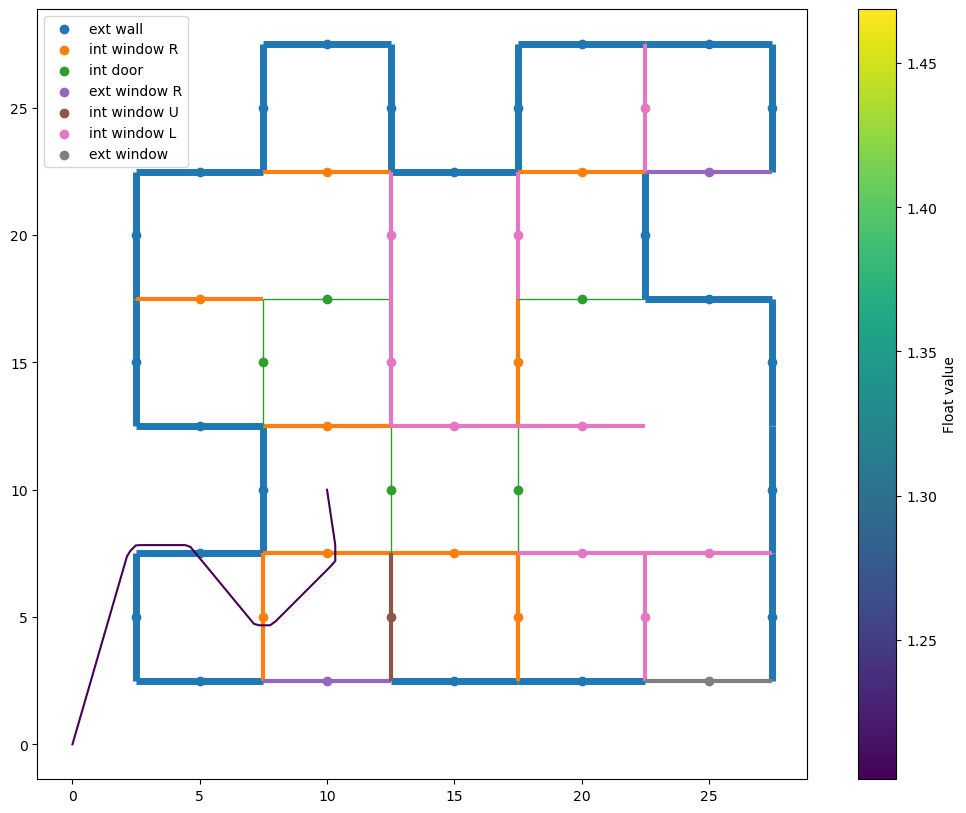

In [16]:
fig, ax = plt.subplots(figsize=(13, 10))
info_map = {
    Building.make_external_wall: (5, "ext wall"),
    Building.make_external_window_left: (3, "ext window L"),
    Building.make_external_window_right: (3, "ext window R"),
    Building.make_external_windows: (3, "ext window"),
    Building.make_external_door: (1, "ext door"),
    Building.make_internal_horizontal_wall_left: (3, "int window L"),
    Building.make_internal_horizontal_wall_right: (3, "int window R"),
    Building.make_internal_vertical_wall: (3, "int window U"),
    Building.make_internal_door: (1, "int door"),

}

for idx, wall_type in enumerate(uav_env.walls.keys()):
    if wall_type == Building.make_internal_no_wall:
        continue

    linewidth, label = info_map[wall_type]

    xs, ys, direcs = [], [], []
    wall_segments = []
    for outdoor_wall in uav_env.walls[wall_type]:
        x, y, direc = outdoor_wall
        xs.append(x)
        ys.append(y)
        direcs.append(direc)
        
        if direc in [Direction.LEFT, Direction.RIGHT]:
            wall_start, wall_end = (x, y + CELL_SIZE / 2), (x, y - CELL_SIZE / 2)
        else:
            wall_start, wall_end = (x + CELL_SIZE / 2, y), (x - CELL_SIZE / 2, y)
        wall_segments.append((wall_start, wall_end))

    color_name = list(mcolors.TABLEAU_COLORS)[idx]
    color = mcolors.TABLEAU_COLORS[color_name]
    wall_collection = mc.LineCollection(wall_segments, linewidths=linewidth, colors=color)
    ax.add_collection(wall_collection)
    ax.scatter(xs, ys, label=label, c=color)
    ax.set_aspect('equal', adjustable='box')

for traj_idx, traj in enumerate(traj_list):
    xs = []
    ys = []
    for t in np.linspace(0, traj.end_time(), 100):
        x, y = traj.value(t).reshape(-1)[:-1]
        xs.append(x)
        ys.append(y)

    xs = np.array(xs)
    ys = np.array(ys)

    time = times[traj_idx]
    ax.plot(xs, ys, color=my_cmap(my_norm(time)))

ax.legend()
fig.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap), orientation="vertical", label="Float value")

In [45]:
meshcat.SetProperty("/Lights/AmbientLight/<object>", "intensity", 1)
meshcat.SetProperty("/Lights/PointLightNegativeX/<object>", "intensity", 0)
meshcat.SetProperty("/Lights/PointLightPositiveX/<object>", "intensity", 0)

In [49]:
trajectories = [best_traj]
fly_in_sequence = False
quadrotor_seperation = None

view_regions = False
track_uav = False

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
ConfigureParser(parser)
parser.AddModelsFromString(uav_env.sdf_as_string, "sdf")
plant.Finalize()

ApplyVisualizationConfig(
        config=VisualizationConfig(publish_inertia=False, publish_contacts=False),
        plant=plant,
        scene_graph=scene_graph,
        builder=builder,
        meshcat=meshcat,
    )

trajectory_colors = (
    cmap_ibm(np.linspace(0, 1, len(trajectories))) if trajectories else []
)

previous_trajectory_end_time = 0.0
total_animation_duration = 0.0
for i, traj in enumerate(trajectories):
    if fly_in_sequence:
        traj = shift_composite_trajectory(traj, previous_trajectory_end_time)
        previous_trajectory_end_time = (
            traj.end_time() + uav_env.DELAY_BETWEEN_TRAJECTORIES
        )
    total_animation_duration = max(total_animation_duration, traj.end_time())

    # Visualize the quadrotor.
    if quadrotor_seperation:
        offsets = np.linspace(
            traj.start_time(),
            traj.end_time(),
            int((traj.end_time() - traj.start_time()) / quadrotor_seperation),
        )
        for j, offset in enumerate(offsets):
            flat_traj_source = builder.AddSystem(
                FlatQuadrotorTrajectorySource(
                    shift_composite_trajectory(traj, -offset)
                )
            )
            QuadrotorGeometry.add_to_builder(
                builder,
                flat_traj_source.get_output_port(0),
                scene_graph,
                f"quadrotor_{i}/{j}",
            )

    else:
        flat_traj_source = builder.AddSystem(
            FlatQuadrotorTrajectorySource(traj)
        )
        QuadrotorGeometry.add_to_builder(
            builder,
            flat_traj_source.get_output_port(0),
            scene_graph,
            f"quadrotor_{i}",
        )

    # Visualize the trajectory.
    cartesian_traj_source = builder.AddSystem(TrajectorySource(traj))
    tracer = builder.AddNamedSystem(
        f"quadrotor_trace_{i}",
        TraceVisualizer(
            meshcat,
            line_width=10, # uav_env.LINE_WIDTH,
            rgba=Rgba(*trajectory_colors[i]),
        ),
    )
    meshcat.SetLine(
        f"/drake/traces/persistent_quadrotor_trace_{i}",
        np.hstack(
            [
                traj.value(t)
                for t in np.linspace(0, traj.end_time(), uav_env.NUM_SAMPLES)
            ]
        ),
        line_width=10, # uav_env.LINE_WIDTH,
        rgba=Rgba(*trajectory_colors[i]),
    )

    meshcat.SetProperty(
        f"/drake/traces/persistent_quadrotor_trace_{i}",
        "visible",
        False,
    )

    builder.Connect(
        cartesian_traj_source.get_output_port(),
        tracer.get_input_port(0),
    )


meshcat_cpp = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

animator = meshcat_cpp.StartRecording()
# if not track_uav:
#     animator = None
# traj_system = builder.AddSystem(FlatnessInverter(trajectory, animator))
# quad = QuadrotorGeometry.AddToBuilder(builder, traj_system.get_output_port(0), scene_graph)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.25)

meshcat.Delete()

if view_regions:
    for ii in range(len(regions)):
        v = VPolytope(regions[ii])
        meshcat.SetTriangleMesh("iris/region_" + str(ii), v.vertices(),
                                ConvexHull(v.vertices().T).simplices.T, Rgba(0.698, 0.67, 1, 0.4))
        
# Simulate
end_time = traj.end_time()
simulator.AdvanceTo(end_time+0.05)
meshcat_cpp.PublishRecording()

with open ("/mnt/trajectory.html", "w") as f:
    f.write(meshcat.StaticHtml())

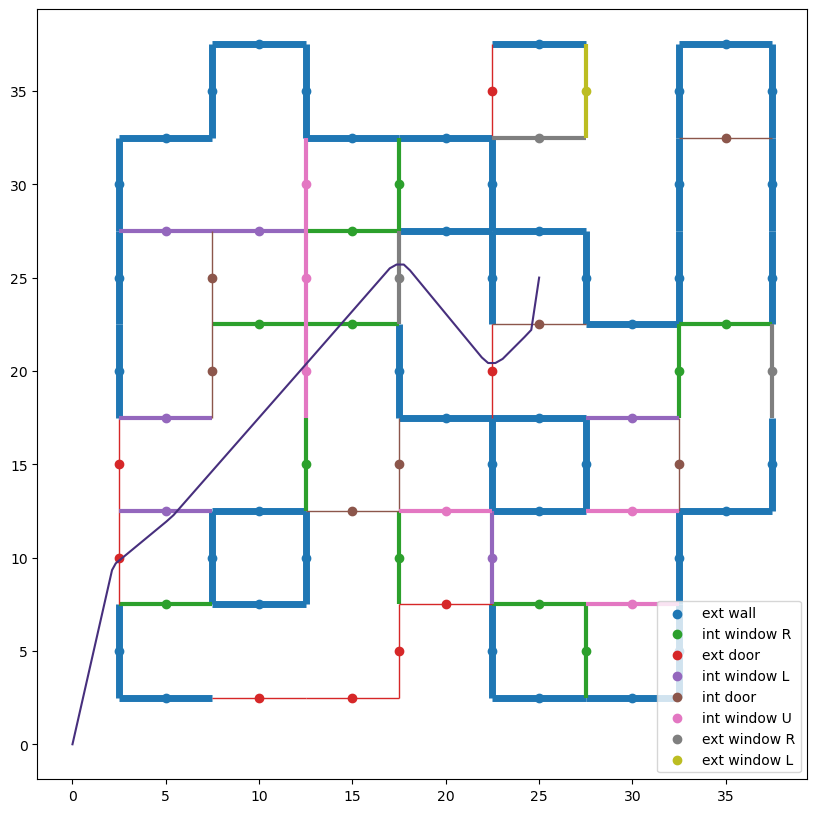

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
info_map = {
    Building.make_external_wall: (5, "ext wall"),
    Building.make_external_window_left: (3, "ext window L"),
    Building.make_external_window_right: (3, "ext window R"),
    Building.make_external_door: (1, "ext door"),
    Building.make_internal_horizontal_wall_left: (3, "int window L"),
    Building.make_internal_horizontal_wall_right: (3, "int window R"),
    Building.make_internal_vertical_wall: (3, "int window U"),
    Building.make_internal_door: (1, "int door"),

}

for idx, wall_type in enumerate(uav_env.walls.keys()):
    if wall_type == Building.make_internal_no_wall:
        continue

    linewidth, label = info_map[wall_type]

    xs, ys, direcs = [], [], []
    wall_segments = []
    for outdoor_wall in uav_env.walls[wall_type]:
        x, y, direc = outdoor_wall
        xs.append(x)
        ys.append(y)
        direcs.append(direc)
        
        if direc in [Direction.LEFT, Direction.RIGHT]:
            wall_start, wall_end = (x, y + CELL_SIZE / 2), (x, y - CELL_SIZE / 2)
        else:
            wall_start, wall_end = (x + CELL_SIZE / 2, y), (x - CELL_SIZE / 2, y)
        wall_segments.append((wall_start, wall_end))

    color_name = list(mcolors.TABLEAU_COLORS)[idx]
    color = mcolors.TABLEAU_COLORS[color_name]
    wall_collection = mc.LineCollection(wall_segments, linewidths=linewidth, colors=color)
    ax.add_collection(wall_collection)
    ax.scatter(xs, ys, label=label, c=color)
    ax.set_aspect('equal', adjustable='box')

for traj_idx, traj in enumerate([best_traj]):
    xs = []
    ys = []
    for t in np.linspace(0, traj.end_time(), 100):
        x, y = traj.value(t).reshape(-1)[:-1]
        xs.append(x)
        ys.append(y)

    xs = np.array(xs)
    ys = np.array(ys)

    time = times[traj_idx]
    ax.plot(xs, ys, color=my_cmap(my_norm(time)))

ax.legend()
# fig.colorbar(cm.ScalarMappable(norm=my_norm, cmap=my_cmap), orientation="vertical", label="Float value")

In [ ]:
# trajectories = [baseline_traj]
# fly_in_sequence = False
# quadrotor_seperation = None

# view_regions = False
# track_uav = False

# builder = DiagramBuilder()
# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
# parser = Parser(plant)
# ConfigureParser(parser)
# parser.AddModelsFromString(uav_env.sdf_as_string, "sdf")
# plant.Finalize()

# ApplyVisualizationConfig(
#         config=VisualizationConfig(publish_inertia=False, publish_contacts=False),
#         plant=plant,
#         scene_graph=scene_graph,
#         builder=builder,
#         meshcat=meshcat,
#     )

# trajectory_colors = (
#     cmap_ibm(np.linspace(0, 1, len(trajectories))) if trajectories else []
# )

# previous_trajectory_end_time = 0.0
# total_animation_duration = 0.0
# for i, traj in enumerate(trajectories):
#     if fly_in_sequence:
#         traj = shift_composite_trajectory(traj, previous_trajectory_end_time)
#         previous_trajectory_end_time = (
#             traj.end_time() + uav_env.DELAY_BETWEEN_TRAJECTORIES
#         )
#     total_animation_duration = max(total_animation_duration, traj.end_time())

#     # Visualize the quadrotor.
#     if quadrotor_seperation:
#         offsets = np.linspace(
#             traj.start_time(),
#             traj.end_time(),
#             int((traj.end_time() - traj.start_time()) / quadrotor_seperation),
#         )
#         for j, offset in enumerate(offsets):
#             flat_traj_source = builder.AddSystem(
#                 FlatQuadrotorTrajectorySource(
#                     shift_composite_trajectory(traj, -offset)
#                 )
#             )
#             QuadrotorGeometry.add_to_builder(
#                 builder,
#                 flat_traj_source.get_output_port(0),
#                 scene_graph,
#                 f"quadrotor_{i}/{j}",
#             )

#     else:
#         flat_traj_source = builder.AddSystem(
#             FlatQuadrotorTrajectorySource(traj)
#         )
#         QuadrotorGeometry.add_to_builder(
#             builder,
#             flat_traj_source.get_output_port(0),
#             scene_graph,
#             f"quadrotor_{i}",
#         )

#     # Visualize the trajectory.
#     cartesian_traj_source = builder.AddSystem(TrajectorySource(traj))
#     tracer = builder.AddNamedSystem(
#         f"quadrotor_trace_{i}",
#         TraceVisualizer(
#             meshcat,
#             line_width=uav_env.LINE_WIDTH,
#             rgba=Rgba(*trajectory_colors[i]),
#         ),
#     )
#     meshcat.SetLine(
#         f"/drake/traces/persistent_quadrotor_trace_{i}",
#         np.hstack(
#             [
#                 traj.value(t)
#                 for t in np.linspace(0, traj.end_time(), uav_env.NUM_SAMPLES)
#             ]
#         ),
#         line_width=uav_env.LINE_WIDTH,
#         rgba=Rgba(*trajectory_colors[i]),
#     )

#     meshcat.SetProperty(
#         f"/drake/traces/persistent_quadrotor_trace_{i}",
#         "visible",
#         False,
#     )

#     builder.Connect(
#         cartesian_traj_source.get_output_port(),
#         tracer.get_input_port(0),
#     )


# meshcat_cpp = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# animator = meshcat_cpp.StartRecording()
# # if not track_uav:
# #     animator = None
# # traj_system = builder.AddSystem(FlatnessInverter(trajectory, animator))
# # quad = QuadrotorGeometry.AddToBuilder(builder, traj_system.get_output_port(0), scene_graph)

# diagram = builder.Build()

# # Set up a simulator to run this diagram
# simulator = Simulator(diagram)
# simulator.set_target_realtime_rate(0.25)

# meshcat.Delete()

# if view_regions:
#     for ii in range(len(regions)):
#         v = VPolytope(regions[ii])
#         meshcat.SetTriangleMesh("iris/region_" + str(ii), v.vertices(),
#                                 ConvexHull(v.vertices().T).simplices.T, Rgba(0.698, 0.67, 1, 0.4))
        
# # Simulate
# end_time = traj.end_time()
# simulator.AdvanceTo(end_time+0.05)
# meshcat_cpp.PublishRecording()

# with open ("/mnt/trajectory.html", "w") as f:
#     f.write(meshcat.StaticHtml())

In [ ]:
max_iters = [40, 50, 100]
max_roundings = [1, 2, 5]

fig, ax = plt.subplots(len(max_iters), len(max_roundings), figsize=(30, 30))
info_map = {
    Building.make_external_wall: (5, "ext wall"),
    Building.make_external_window_left: (3, "ext window L"),
    Building.make_external_window_right: (3, "ext window R"),
    Building.make_external_door: (1, "ext door"),
    Building.make_internal_horizontal_wall_left: (3, "int window L"),
    Building.make_internal_horizontal_wall_right: (3, "int window R"),
    Building.make_internal_vertical_wall: (3, "int window U"),
    Building.make_internal_door: (1, "int door"),

}

for row, max_iter in enumerate(max_iters):
    for col, max_rounding_paths in enumerate(max_roundings):
        title = f"max iters: {max_iter}, max rounding paths: {max_rounding_paths}"
        print(title)

        CONVEX_GCS_OPTION.solver_options.SetOption(
            CONVEX_GCS_OPTION.solver.solver_id(),
            "max_iter", max_iter
        )

        CONVEX_GCS_OPTION.max_rounded_paths = max_rounding_paths
        baseline_traj = solve_gcs()

        for idx, wall_type in enumerate(info_map.keys()):
            if wall_type not in uav_env.walls.keys():
                continue

            linewidth, label = info_map[wall_type]

            xs, ys, dirs = [], [], []
            wall_segments = []
            for outdoor_wall in uav_env.walls[wall_type]:
                x, y, dir = outdoor_wall
                xs.append(x)
                ys.append(y)
                dirs.append(dir)
                
                if dir in [Direction.LEFT, Direction.RIGHT]:
                    wall_start, wall_end = (x, y + CELL_SIZE / 2), (x, y - CELL_SIZE / 2)
                else:
                    wall_start, wall_end = (x + CELL_SIZE / 2, y), (x - CELL_SIZE / 2, y)
                wall_segments.append((wall_start, wall_end))

            color_name = list(mcolors.TABLEAU_COLORS)[idx]
            color = mcolors.TABLEAU_COLORS[color_name]
            wall_collection = mc.LineCollection(wall_segments, linewidths=linewidth, colors=color)
            ax[row, col].add_collection(wall_collection)
            ax[row, col].scatter(xs, ys, label=label, c=color)

        xs = []
        ys = []
        for t in np.linspace(0, baseline_traj.end_time(), 100):
            x, y = baseline_traj.value(t).reshape(-1)[:-1]
            xs.append(x)
            ys.append(y)

        xs = np.array(xs)
        ys = np.array(ys)
        
        ax[row, col].plot(xs, ys)
        ax[row, col].set_aspect('equal', adjustable='box')
        ax[row, col].legend()
        ax[row, col].set_title(title)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
info_map = {
    Building.make_external_wall: (5, "ext wall"),
    Building.make_external_window_left: (3, "ext window L"),
    Building.make_external_window_right: (3, "ext window R"),
    Building.make_external_door: (1, "ext door"),
    Building.make_internal_horizontal_wall_left: (3, "int window L"),
    Building.make_internal_horizontal_wall_right: (3, "int window R"),
    Building.make_internal_vertical_wall: (3, "int window U"),
    Building.make_internal_door: (1, "int door"),

}

for idx, wall_type in enumerate(uav_env.walls.keys()):
    if wall_type == Building.make_internal_no_wall:
        continue

    linewidth, label = info_map[wall_type]

    xs, ys, dirs = [], [], []
    wall_segments = []
    for outdoor_wall in uav_env.walls[wall_type]:
        x, y, dir = outdoor_wall
        xs.append(x)
        ys.append(y)
        dirs.append(dir)
        
        if dir in [Direction.LEFT, Direction.RIGHT]:
            wall_start, wall_end = (x, y + CELL_SIZE / 2), (x, y - CELL_SIZE / 2)
        else:
            wall_start, wall_end = (x + CELL_SIZE / 2, y), (x - CELL_SIZE / 2, y)
        wall_segments.append((wall_start, wall_end))

    color_name = list(mcolors.TABLEAU_COLORS)[idx]
    color = mcolors.TABLEAU_COLORS[color_name]
    wall_collection = mc.LineCollection(wall_segments, linewidths=linewidth, colors=color)
    ax.add_collection(wall_collection)
    ax.scatter(xs, ys, label=label, c=color)
    ax.set_aspect('equal', adjustable='box')

xs = []
ys = []
for t in np.linspace(0, baseline_traj.end_time(), 100):
    x, y = baseline_traj.value(t).reshape(-1)[:-1]
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)
ax.plot(xs, ys)

ax.legend()